### PROFESSIONAL BRAIN TUMOR DETECTION SYSTEM
#### Using Transfer Learning with VGG16 and Advanced Computer Vision Techniques

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# =============================================================================
# LIBRARY IMPORTS
# =============================================================================
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from typing import Tuple, List, Generator

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Flatten, Dropout, Dense,
                                     BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping,
                                        ReduceLROnPlateau)
from tensorflow.keras.regularizers import l2

# Image Processing
from PIL import Image, ImageEnhance
import cv2

# Machine Learning Utilities
from sklearn.utils import shuffle
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_curve, auc, f1_score, accuracy_score)
from sklearn.preprocessing import label_binarize

# Suppress warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("=" * 80)
print("BRAIN TUMOR DETECTION SYSTEM - INITIALIZATION COMPLETE")
print("=" * 80)
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU'))} GPU(s)")
print("=" * 80)

BRAIN TUMOR DETECTION SYSTEM - INITIALIZATION COMPLETE
TensorFlow Version: 2.19.0
GPU Available: 1 GPU(s)


In [50]:
# =============================================================================
# CONFIGURATION PARAMETERS
# =============================================================================
class Config:
    """Centralized configuration for the entire pipeline"""

    # Paths
    BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/MRI images'
    TRAIN_DIR = os.path.join(BASE_DIR, 'Training')
    TEST_DIR = os.path.join(BASE_DIR, 'Testing')
    MODEL_SAVE_PATH = '/content/drive/MyDrive/brain_tumor_model_vgg16.h5'
    CHECKPOINT_DIR = '/content/drive/MyDrive/checkpoints'

    # Model Parameters
    IMAGE_SIZE = 128
    BATCH_SIZE = 32
    EPOCHS = 20
    LEARNING_RATE = 1e-4
    VALIDATION_SPLIT = 0.2

    # Augmentation Parameters
    BRIGHTNESS_RANGE = (0.7, 1.3)
    CONTRAST_RANGE = (0.7, 1.3)
    ROTATION_RANGE = 15

    # Class Names
    CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']
    NUM_CLASSES = len(CLASS_NAMES)

    # Training Parameters
    EARLY_STOPPING_PATIENCE = 7
    REDUCE_LR_PATIENCE = 3
    REDUCE_LR_FACTOR = 0.5

# Create necessary directories
os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)

print(f"\n✓ Configuration loaded successfully")
print(f"✓ Training on {Config.NUM_CLASSES} classes: {Config.CLASS_NAMES}")



✓ Configuration loaded successfully
✓ Training on 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [51]:
# =============================================================================
# DATA LOADING AND PREPROCESSING
# =============================================================================

class DataLoader:
    """Professional data loading with validation and statistics"""

    @staticmethod
    def load_dataset(directory: str, shuffle_data: bool = True) -> Tuple[List[str], List[str]]:
        """Load dataset paths and labels with comprehensive validation"""
        paths = []
        labels = []

        if not os.path.exists(directory):
            raise FileNotFoundError(f"Directory not found: {directory}")

        class_distribution = {}

        for label in os.listdir(directory):
            label_path = os.path.join(directory, label)
            if not os.path.isdir(label_path):
                continue

            image_files = [f for f in os.listdir(label_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            class_distribution[label] = len(image_files)

            for image_file in image_files:
                paths.append(os.path.join(label_path, image_file))
                labels.append(label)

        # Shuffle if requested
        if shuffle_data:
            paths, labels = shuffle(paths, labels, random_state=RANDOM_SEED)

        # Print statistics
        print(f"\n{'='*60}")
        print(f"Dataset: {os.path.basename(directory)}")
        print(f"{'='*60}")
        print(f"Total Images: {len(paths)}")
        print(f"\nClass Distribution:")
        for class_name, count in sorted(class_distribution.items()):
            percentage = (count / len(paths)) * 100
            print(f"  {class_name:15s}: {count:5d} images ({percentage:.2f}%)")
        print(f"{'='*60}")

        return paths, labels

    @staticmethod
    def encode_labels(labels: List[str]) -> np.ndarray:
        """Encode string labels to integers"""
        label_map = {label: idx for idx, label in enumerate(Config.CLASS_NAMES)}
        encoded = np.array([label_map[label] for label in labels])
        return encoded

    @staticmethod
    def split_validation(paths: List[str], labels: List[str],
                        val_split: float = 0.2) -> Tuple:
        """Split data into training and validation sets"""
        split_idx = int(len(paths) * (1 - val_split))

        train_paths = paths[:split_idx]
        train_labels = labels[:split_idx]
        val_paths = paths[split_idx:]
        val_labels = labels[split_idx:]

        print(f"\n✓ Data split: {len(train_paths)} training, {len(val_paths)} validation")

        return train_paths, train_labels, val_paths, val_labels

# Load datasets
print("\n" + "="*80)
print("LOADING DATASETS")
print("="*80)

train_paths, train_labels = DataLoader.load_dataset(Config.TRAIN_DIR)
test_paths, test_labels = DataLoader.load_dataset(Config.TEST_DIR)

# Split training data for validation
train_paths, train_labels, val_paths, val_labels = DataLoader.split_validation(
    train_paths, train_labels, Config.VALIDATION_SPLIT
)


LOADING DATASETS

Dataset: Training
Total Images: 5749

Class Distribution:
  glioma         :  1330 images (23.13%)
  meningioma     :  1339 images (23.29%)
  notumor        :  1619 images (28.16%)
  pituitary      :  1461 images (25.41%)

Dataset: Testing
Total Images: 1311

Class Distribution:
  glioma         :   300 images (22.88%)
  meningioma     :   306 images (23.34%)
  notumor        :   405 images (30.89%)
  pituitary      :   300 images (22.88%)

✓ Data split: 4599 training, 1150 validation



DATA VISUALIZATION


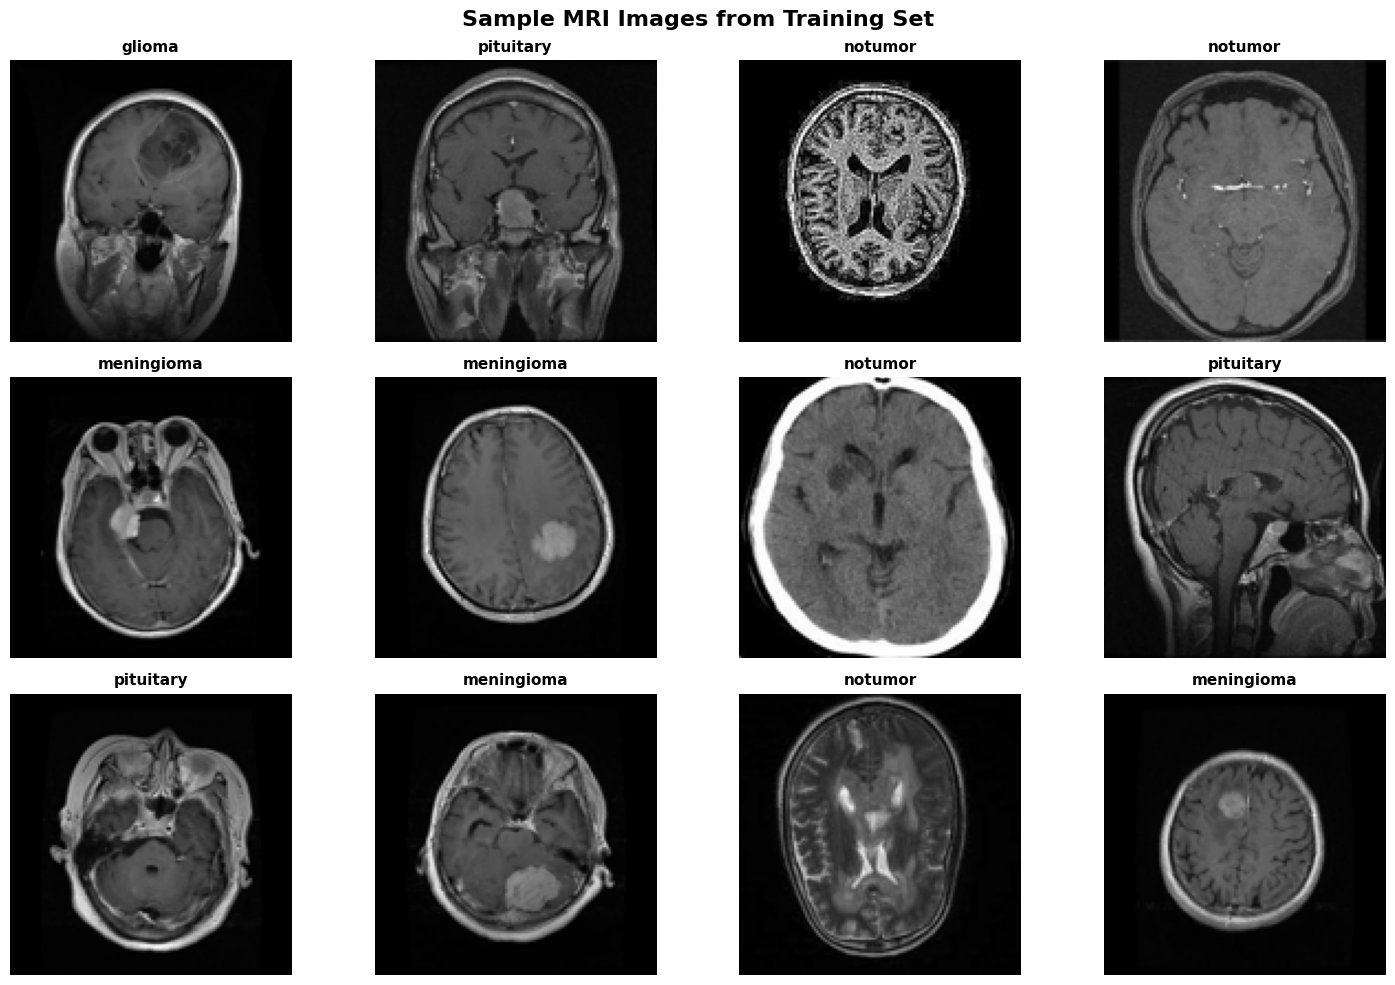

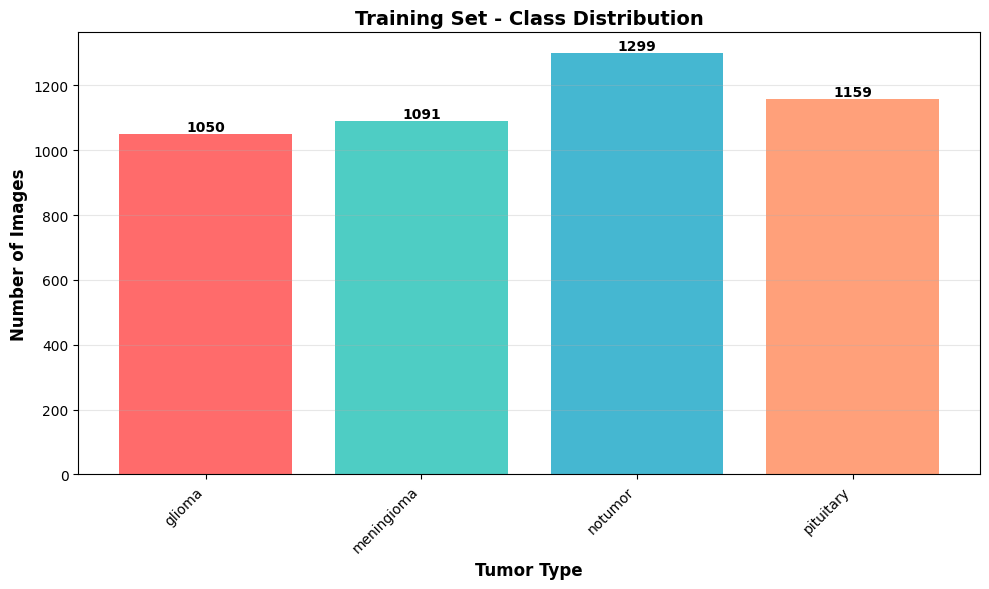

In [52]:
# =============================================================================
# DATA VISUALIZATION
# =============================================================================

class Visualizer:
    """Professional visualization utilities"""

    @staticmethod
    def plot_sample_images(paths: List[str], labels: List[str],
                          n_samples: int = 12, figsize: Tuple = (15, 10)):
        """Display sample images with labels"""

        indices = random.sample(range(len(paths)), min(n_samples, len(paths)))

        rows = 3
        cols = 4
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        axes = axes.ravel()

        for i, idx in enumerate(indices):
            img = Image.open(paths[idx])
            img = img.resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE))

            axes[i].imshow(img, cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f"{labels[idx]}", fontsize=11, fontweight='bold')

        plt.suptitle('Sample MRI Images from Training Set',
                    fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_class_distribution(labels: List[str], title: str = "Class Distribution"):
        """Plot class distribution bar chart"""

        unique, counts = np.unique(labels, return_counts=True)

        plt.figure(figsize=(10, 6))
        bars = plt.bar(unique, counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])

        plt.xlabel('Tumor Type', fontsize=12, fontweight='bold')
        plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xticks(rotation=45, ha='right')

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontweight='bold')

        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

# Visualize data
print("\n" + "="*80)
print("DATA VISUALIZATION")
print("="*80)

Visualizer.plot_sample_images(train_paths, train_labels)
Visualizer.plot_class_distribution(train_labels, "Training Set - Class Distribution")

In [53]:
# =============================================================================
# ADVANCED IMAGE PREPROCESSING & AUGMENTATION
# =============================================================================

class ImagePreprocessor:
    """Advanced image preprocessing with multiple augmentation techniques"""

    @staticmethod
    def advanced_augmentation(image: np.ndarray, training: bool = True) -> np.ndarray:
        """Apply advanced augmentation techniques"""
        if not training:
            return image / 255.0

        img_pil = Image.fromarray(np.uint8(image))

        # Random brightness adjustment
        if random.random() > 0.5:
            brightness_factor = random.uniform(*Config.BRIGHTNESS_RANGE)
            img_pil = ImageEnhance.Brightness(img_pil).enhance(brightness_factor)

        # Random contrast adjustment
        if random.random() > 0.5:
            contrast_factor = random.uniform(*Config.CONTRAST_RANGE)
            img_pil = ImageEnhance.Contrast(img_pil).enhance(contrast_factor)

        # Random rotation
        if random.random() > 0.5:
            angle = random.uniform(-Config.ROTATION_RANGE, Config.ROTATION_RANGE)
            img_pil = img_pil.rotate(angle, fillcolor=(0, 0, 0))

        # Random horizontal flip
        if random.random() > 0.5:
            img_pil = img_pil.transpose(Image.FLIP_LEFT_RIGHT)

        # Convert back to array and normalize
        img_array = np.array(img_pil) / 255.0

        # Add slight Gaussian noise
        if random.random() > 0.7:
            noise = np.random.normal(0, 0.02, img_array.shape)
            img_array = np.clip(img_array + noise, 0, 1)

        return img_array

    @staticmethod
    def preprocess_image(path: str, training: bool = True) -> np.ndarray:
        """Load and preprocess a single image"""
        try:
            image = load_img(path, target_size=(Config.IMAGE_SIZE, Config.IMAGE_SIZE))
            image = np.array(image)
            image = ImagePreprocessor.advanced_augmentation(image, training)
            return image
        except Exception as e:
            print(f"Error loading image {path}: {str(e)}")
            return np.zeros((Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3))

    @staticmethod
    def batch_preprocess(paths: List[str], training: bool = True) -> np.ndarray:
        """Preprocess a batch of images"""
        images = [ImagePreprocessor.preprocess_image(path, training)
                 for path in paths]
        return np.array(images)


In [54]:
# =============================================================================
# DATA GENERATOR - FIXED VERSION
# =============================================================================

def data_generator(paths: List[str], labels: List[str],
                  batch_size: int = Config.BATCH_SIZE,
                  training: bool = True) -> Generator:
    """Memory-efficient data generator with augmentation - Fixed for batch size consistency"""

    num_samples = len(paths)

    while True:
        # Create copies to avoid modifying original lists
        if training:
            paths_epoch, labels_epoch = shuffle(list(paths), list(labels), random_state=None)
        else:
            paths_epoch, labels_epoch = list(paths), list(labels)

        for offset in range(0, num_samples, batch_size):
            batch_end = min(offset + batch_size, num_samples)

            # Skip incomplete batches
            if batch_end - offset != batch_size:
                continue

            batch_paths = paths_epoch[offset:batch_end]
            batch_labels = labels_epoch[offset:batch_end]

            # Preprocess images
            batch_images = ImagePreprocessor.batch_preprocess(batch_paths, training)

            # Encode labels
            batch_labels_encoded = DataLoader.encode_labels(batch_labels)

            yield batch_images, batch_labels_encoded

print("\n✓ Data pipeline configured successfully")


✓ Data pipeline configured successfully


In [55]:
# =============================================================================
# MODEL ARCHITECTURE - FIXED VERSION
# =============================================================================

class BrainTumorModel:
    """Professional model builder with advanced architecture"""

    @staticmethod
    def build_model(fine_tune_layers: int = 4):
        """Build VGG16-based model with custom classification head"""
        print("\n" + "="*80)
        print("BUILDING MODEL ARCHITECTURE")
        print("="*80)

        # Load VGG16 base model
        base_model = VGG16(
            input_shape=(Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3),
            include_top=False,
            weights='imagenet'
        )

        # Freeze base model layers
        base_model.trainable = False

        print(f"✓ VGG16 base model loaded")

        # Build complete model using Functional API
        inputs = Input(shape=(Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3))
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.3)(x)
        outputs = Dense(Config.NUM_CLASSES, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs, name='BrainTumorClassifier')

        # After initial compilation, unfreeze last layers
        if fine_tune_layers > 0:
            base_model.trainable = True
            # Freeze all layers except the last few
            for layer in base_model.layers[:-fine_tune_layers]:
                layer.trainable = False
            print(f"✓ Fine-tuning last {fine_tune_layers} layers of VGG16")

        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=Config.LEARNING_RATE),
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

        print(f"✓ Model compiled successfully")
        print(f"\nModel Summary:")
        print("="*80)
        model.summary()

        # Count trainable parameters
        trainable_params = sum([np.prod(w.shape) for w in model.trainable_weights])
        total_params = sum([np.prod(w.shape) for w in model.weights])

        print("="*80)
        print(f"Trainable Parameters: {trainable_params:,}")
        print(f"Total Parameters: {total_params:,}")
        print(f"Trainable Ratio: {(trainable_params/total_params)*100:.2f}%")
        print("="*80)

        return model

# Build model
model = BrainTumorModel.build_model(fine_tune_layers=4)


BUILDING MODEL ARCHITECTURE
✓ VGG16 base model loaded
✓ Fine-tuning last 4 layers of VGG16
✓ Model compiled successfully

Model Summary:


Model: "BrainTumorClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,882,500 (56.77 MB)

 Trainable params: 7,245,700 (27.64 MB)

 Non-trainable params: 7,636,800 (29.13 MB)

Trainable Parameters: 7,245,700
Total Parameters: 14,882,500
Trainable Ratio: 48.69%


In [56]:
# =============================================================================
# TRAINING CALLBACKS
# =============================================================================

# Model checkpoint - save best model
checkpoint_path = os.path.join(Config.CHECKPOINT_DIR,
                              'best_model_epoch_{epoch:02d}_acc_{val_sparse_categorical_accuracy:.4f}.h5')
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_weights_only=False
)

# Early stopping - stop if no improvement
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=Config.EARLY_STOPPING_PATIENCE,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

# Learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=Config.REDUCE_LR_FACTOR,
    patience=Config.REDUCE_LR_PATIENCE,
    min_lr=1e-7,
    verbose=1,
    mode='min'
)

callbacks = [checkpoint, early_stopping, reduce_lr]

print("\n✓ Training callbacks configured")


✓ Training callbacks configured


In [57]:
# =============================================================================
# MODEL TRAINING
# =============================================================================

print("\n" + "="*80)
print("STARTING MODEL TRAINING")
print("="*80)

# Calculate steps (only complete batches)
steps_per_epoch = len(train_paths) // Config.BATCH_SIZE
validation_steps = len(val_paths) // Config.BATCH_SIZE

# Ensure we have at least some steps
if steps_per_epoch == 0:
    raise ValueError(f"Not enough training samples ({len(train_paths)}) for batch size {Config.BATCH_SIZE}")
if validation_steps == 0:
    raise ValueError(f"Not enough validation samples ({len(val_paths)}) for batch size {Config.BATCH_SIZE}")

print(f"\nTraining Configuration:")
print(f"  Epochs: {Config.EPOCHS}")
print(f"  Batch Size: {Config.BATCH_SIZE}")
print(f"  Training Samples: {len(train_paths)} ({steps_per_epoch} complete batches)")
print(f"  Validation Samples: {len(val_paths)} ({validation_steps} complete batches)")
print(f"  Steps per Epoch: {steps_per_epoch}")
print(f"  Validation Steps: {validation_steps}")
print(f"  Learning Rate: {Config.LEARNING_RATE}")
print("\n" + "="*80)

# Train the model
history = model.fit(
    data_generator(train_paths, train_labels, Config.BATCH_SIZE, training=True),
    steps_per_epoch=steps_per_epoch,
    epochs=Config.EPOCHS,
    validation_data=data_generator(val_paths, val_labels, Config.BATCH_SIZE, training=False),
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*80)
print("✓ TRAINING COMPLETED SUCCESSFULLY")
print("="*80)



STARTING MODEL TRAINING

Training Configuration:
  Epochs: 20
  Batch Size: 32
  Training Samples: 4599 (143 complete batches)
  Validation Samples: 1150 (35 complete batches)
  Steps per Epoch: 143
  Validation Steps: 35
  Learning Rate: 0.0001

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 1.7112 - sparse_categorical_accuracy: 0.5543
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.61875, saving model to /content/drive/MyDrive/checkpoints/best_model_epoch_01_acc_0.6187.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 1349s 9s/step - loss: 1.7094 - sparse_categorical_accuracy: 0.5550 - val_loss: 1.5059 - val_sparse_categorical_accuracy: 0.6187 - learning_rate: 1.0000e-04
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 1.0616 - sparse_categorical_accuracy: 0.7894
Epoch 2: val_sparse_categorical_accuracy improved from 0.61875 to 0.74286, saving model to /content/drive/MyDrive/checkpoints/best_model_epoch_02_acc_0.7429.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 264ms/step - loss: 1.0614 - sparse_categorical_accuracy: 0.7895 - val_loss: 1.3623 - val_sparse_categorical_accuracy: 0.7429 - learning_rate: 1.0000e-04
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.9309 - sparse_categorical_accuracy: 0.8430
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.74286
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 224ms/step - loss: 0.9307 - sparse_categorical_accuracy: 0.8430 - val_loss: 1.1121 - val_sparse_categorical_accuracy: 0.7357 - learning_rate: 1.0000e-04
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.8415 - sparse_categorical_accuracy: 0.8669
Epoch 4: val_sparse_categorical_accuracy improved from 0.74286 to 0.85357, saving model to /content/drive/MyDrive/checkpoints/best_model_epoch_04_acc_0.8536.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 222ms/step - loss: 0.8414 - sparse_categorical_accuracy: 0.8669 - val_loss: 0.8986 - val_sparse_categorical_accuracy: 0.8536 - learning_rate: 1.0000e-04
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.7762 - sparse_categorical_accuracy: 0.8898
Epoch 5: val_sparse_categorical_accuracy improved from 0.85357 to 0.89821, saving model to /content/drive/MyDrive/checkpoints/best_model_epoch_05_acc_0.8982.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - loss: 0.7762 - sparse_categorical_accuracy: 0.8898 - val_loss: 0.7747 - val_sparse_categorical_accuracy: 0.8982 - learning_rate: 1.0000e-04
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.7236 - sparse_categorical_accuracy: 0.9021
Epoch 6: val_sparse_categorical_accuracy improved from 0.89821 to 0.90893, saving model to /content/drive/MyDrive/checkpoints/best_model_epoch_06_acc_0.9089.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 219ms/step - loss: 0.7235 - sparse_categorical_accuracy: 0.9021 - val_loss: 0.7225 - val_sparse_categorical_accuracy: 0.9089 - learning_rate: 1.0000e-04
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.6667 - sparse_categorical_accuracy: 0.9264
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.90893
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 214ms/step - loss: 0.6669 - sparse_categorical_accuracy: 0.9264 - val_loss: 0.9098 - val_sparse_categorical_accuracy: 0.8429 - learning_rate: 1.0000e-04
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.6600 - sparse_categorical_accuracy: 0.9281
Epoch 8: val_sparse_categorical_accuracy did not improve from 0.90893
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 216ms/step - loss: 0.6600 - sparse_categorical_accuracy: 0.9281 - val_loss: 0.7176 - val_sparse_categorical_accuracy: 0.8955 - learning_rate: 1.0000e-04
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.6344 - sparse_categorica

143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 220ms/step - loss: 0.6091 - sparse_categorical_accuracy: 0.9390 - val_loss: 0.5946 - val_sparse_categorical_accuracy: 0.9393 - learning_rate: 1.0000e-04
Epoch 12/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.5633 - sparse_categorical_accuracy: 0.9477
Epoch 12: val_sparse_categorical_accuracy improved from 0.93929 to 0.94911, saving model to /content/drive/MyDrive/checkpoints/best_model_epoch_12_acc_0.9491.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 217ms/step - loss: 0.5634 - sparse_categorical_accuracy: 0.9478 - val_loss: 0.5769 - val_sparse_categorical_accuracy: 0.9491 - learning_rate: 1.0000e-04
Epoch 13/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.5376 - sparse_categorical_accuracy: 0.9606
Epoch 13: val_sparse_categorical_accuracy improved from 0.94911 to 0.95179, saving model to /content/drive/MyDrive/checkpoints/best_model_epoch_13_acc_0.9518.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 220ms/step - loss: 0.5376 - sparse_categorical_accuracy: 0.9606 - val_loss: 0.5492 - val_sparse_categorical_accuracy: 0.9518 - learning_rate: 1.0000e-04
Epoch 14/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.5232 - sparse_categorical_accuracy: 0.9621
Epoch 14: val_sparse_categorical_accuracy did not improve from 0.95179
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step - loss: 0.5233 - sparse_categorical_accuracy: 0.9621 - val_loss: 0.6102 - val_sparse_categorical_accuracy: 0.9420 - learning_rate: 1.0000e-04
Epoch 15/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.5247 - sparse_categorical_accuracy: 0.9604
Epoch 15: val_sparse_categorical_accuracy did not improve from 0.95179
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - loss: 0.5246 - sparse_categorical_accuracy: 0.9604 - val_loss: 0.5980 - val_sparse_categorical_accuracy: 0.9330 - learning_rate: 1.0000e-04
Epoch 16/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.5059 - sparse_categ

143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 220ms/step - loss: 0.5058 - sparse_categorical_accuracy: 0.9675 - val_loss: 0.5222 - val_sparse_categorical_accuracy: 0.9536 - learning_rate: 1.0000e-04
Epoch 17/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.4683 - sparse_categorical_accuracy: 0.9786
Epoch 17: val_sparse_categorical_accuracy did not improve from 0.95357
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - loss: 0.4683 - sparse_categorical_accuracy: 0.9786 - val_loss: 0.5528 - val_sparse_categorical_accuracy: 0.9536 - learning_rate: 1.0000e-04
Epoch 18/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.4772 - sparse_categorical_accuracy: 0.9685
Epoch 18: val_sparse_categorical_accuracy did not improve from 0.95357
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 214ms/step - loss: 0.4772 - sparse_categorical_accuracy: 0.9686 - val_loss: 0.5815 - val_sparse_categorical_accuracy: 0.9384 - learning_rate: 1.0000e-04
Epoch 19/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.4600 - sparse_categ

143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 215ms/step - loss: 0.4435 - sparse_categorical_accuracy: 0.9817 - val_loss: 0.4561 - val_sparse_categorical_accuracy: 0.9768 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 20.

✓ TRAINING COMPLETED SUCCESSFULLY


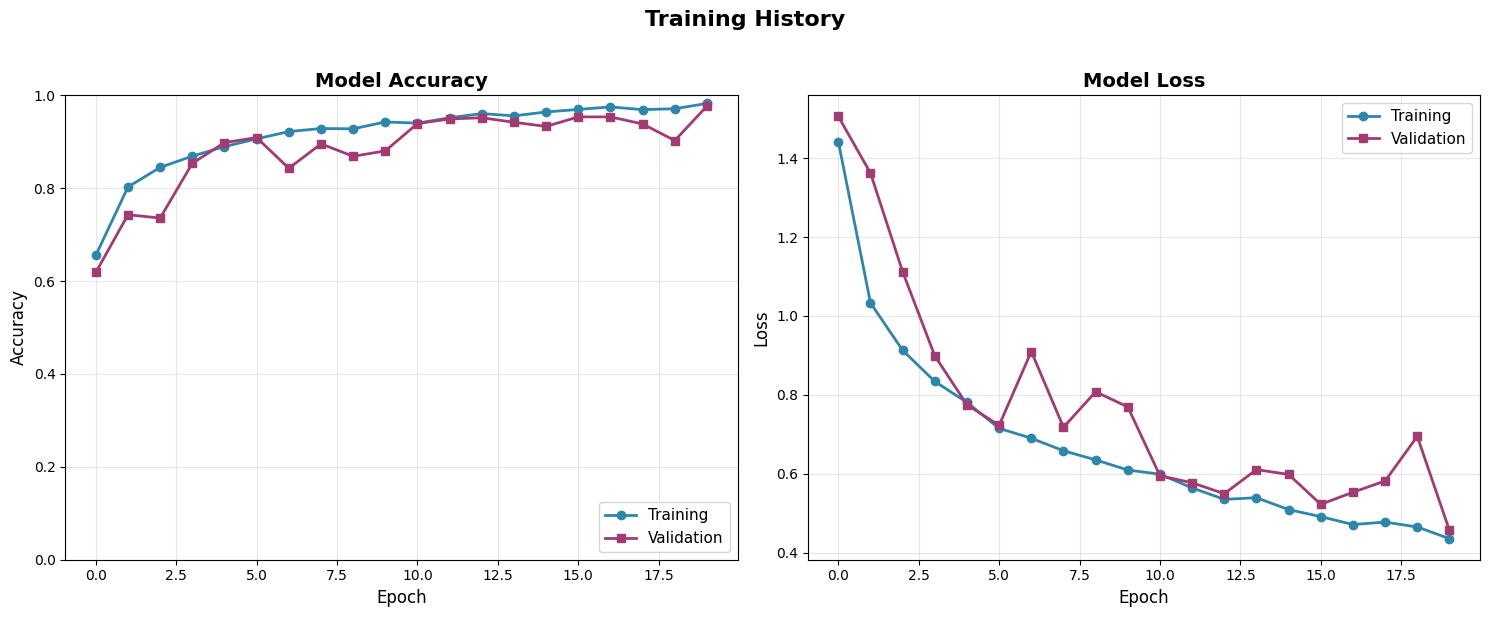


TRAINING SUMMARY
Best Validation Accuracy: 97.68% (Epoch 20)
Best Validation Loss: 0.4561 (Epoch 20)
Final Training Accuracy: 98.25%
Final Validation Accuracy: 97.68%


In [58]:
# =============================================================================
# TRAINING VISUALIZATION
# =============================================================================

class TrainingVisualizer:
    """Visualize training metrics"""

    @staticmethod
    def plot_training_history(history):
        """Plot comprehensive training history"""

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Accuracy
        axes[0].plot(history.history['sparse_categorical_accuracy'],
                       'o-', label='Training', linewidth=2, markersize=6, color='#2E86AB')
        axes[0].plot(history.history['val_sparse_categorical_accuracy'],
                       's-', label='Validation', linewidth=2, markersize=6, color='#A23B72')
        axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Accuracy', fontsize=12)
        axes[0].legend(loc='lower right', fontsize=11)
        axes[0].grid(True, alpha=0.3)
        axes[0].set_ylim([0, 1])

        # Loss
        axes[1].plot(history.history['loss'],
                       'o-', label='Training', linewidth=2, markersize=6, color='#2E86AB')
        axes[1].plot(history.history['val_loss'],
                       's-', label='Validation', linewidth=2, markersize=6, color='#A23B72')
        axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Loss', fontsize=12)
        axes[1].legend(loc='upper right', fontsize=11)
        axes[1].grid(True, alpha=0.3)

        plt.suptitle('Training History',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

        # Print best metrics
        best_val_acc = max(history.history['val_sparse_categorical_accuracy'])
        best_val_acc_epoch = history.history['val_sparse_categorical_accuracy'].index(best_val_acc) + 1
        best_val_loss = min(history.history['val_loss'])
        best_val_loss_epoch = history.history['val_loss'].index(best_val_loss) + 1

        print("\n" + "="*60)
        print("TRAINING SUMMARY")
        print("="*60)
        print(f"Best Validation Accuracy: {best_val_acc*100:.2f}% (Epoch {best_val_acc_epoch})")
        print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_val_loss_epoch})")
        print(f"Final Training Accuracy: {history.history['sparse_categorical_accuracy'][-1]*100:.2f}%")
        print(f"Final Validation Accuracy: {history.history['val_sparse_categorical_accuracy'][-1]*100:.2f}%")
        print("="*60)

# Plot training history
TrainingVisualizer.plot_training_history(history)

In [59]:
# =============================================================================
# MODEL EVALUATION ON TEST SET
# =============================================================================

print("\n" + "="*80)
print("EVALUATING MODEL ON TEST SET")
print("="*80)

# Load and preprocess test images
test_images = ImagePreprocessor.batch_preprocess(test_paths, training=False)
test_labels_encoded = DataLoader.encode_labels(test_labels)

# Make predictions
print("\n✓ Generating predictions...")
test_predictions = model.predict(test_images, batch_size=Config.BATCH_SIZE, verbose=1)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Calculate metrics
test_accuracy = accuracy_score(test_labels_encoded, test_pred_classes)
test_f1 = f1_score(test_labels_encoded, test_pred_classes, average='weighted')

print(f"\n{'='*80}")
print(f"TEST SET PERFORMANCE")
print(f"{'='*80}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"{'='*80}")


EVALUATING MODEL ON TEST SET

✓ Generating predictions...
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step

TEST SET PERFORMANCE
Test Accuracy: 97.56%
Test F1-Score: 0.9755


In [60]:
# =============================================================================
# CLASSIFICATION REPORT
# =============================================================================

print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print("\n")

report = classification_report(
    test_labels_encoded,
    test_pred_classes,
    target_names=Config.CLASS_NAMES,
    digits=4
)
print(report)


DETAILED CLASSIFICATION REPORT


              precision    recall  f1-score   support

      glioma     0.9828    0.9533    0.9679       300
  meningioma     0.9510    0.9510    0.9510       306
     notumor     0.9951    0.9951    0.9951       405
   pituitary     0.9676    0.9967    0.9819       300

    accuracy                         0.9756      1311
   macro avg     0.9741    0.9740    0.9740      1311
weighted avg     0.9757    0.9756    0.9755      1311



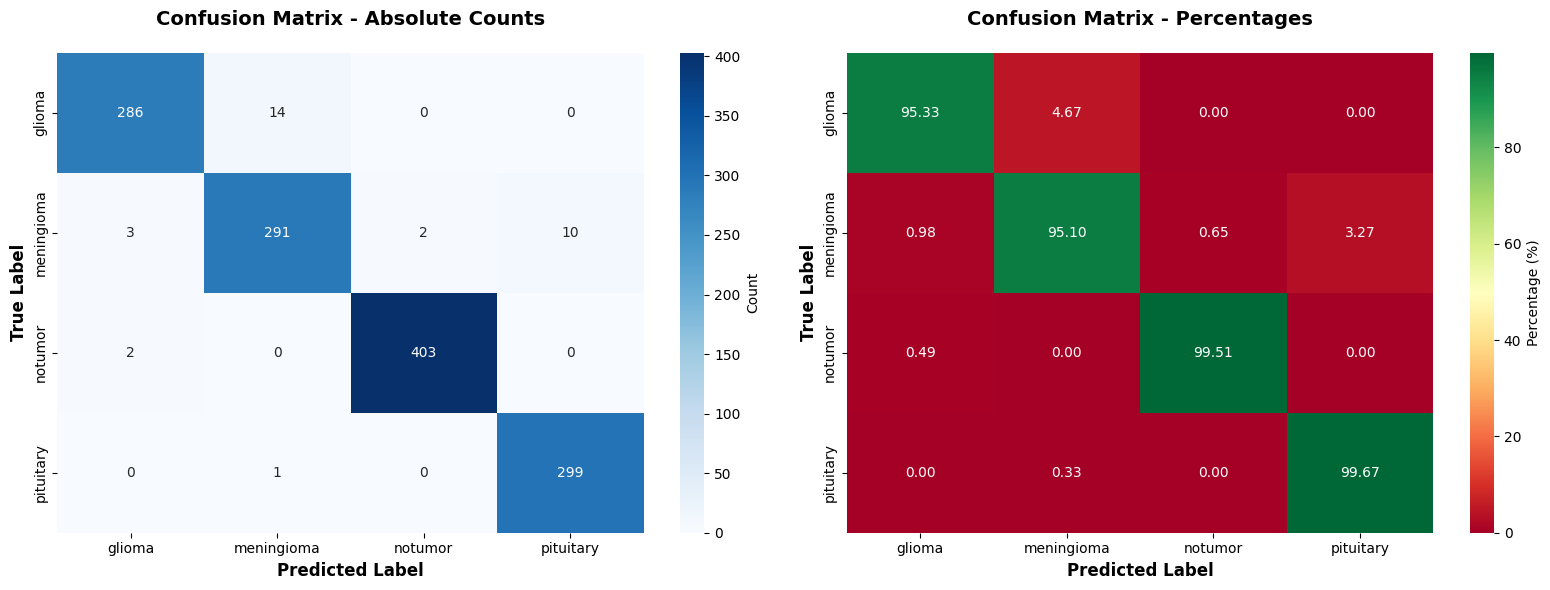


Per-Class Accuracy:
glioma         :  95.33%
meningioma     :  95.10%
notumor        :  99.51%
pituitary      :  99.67%


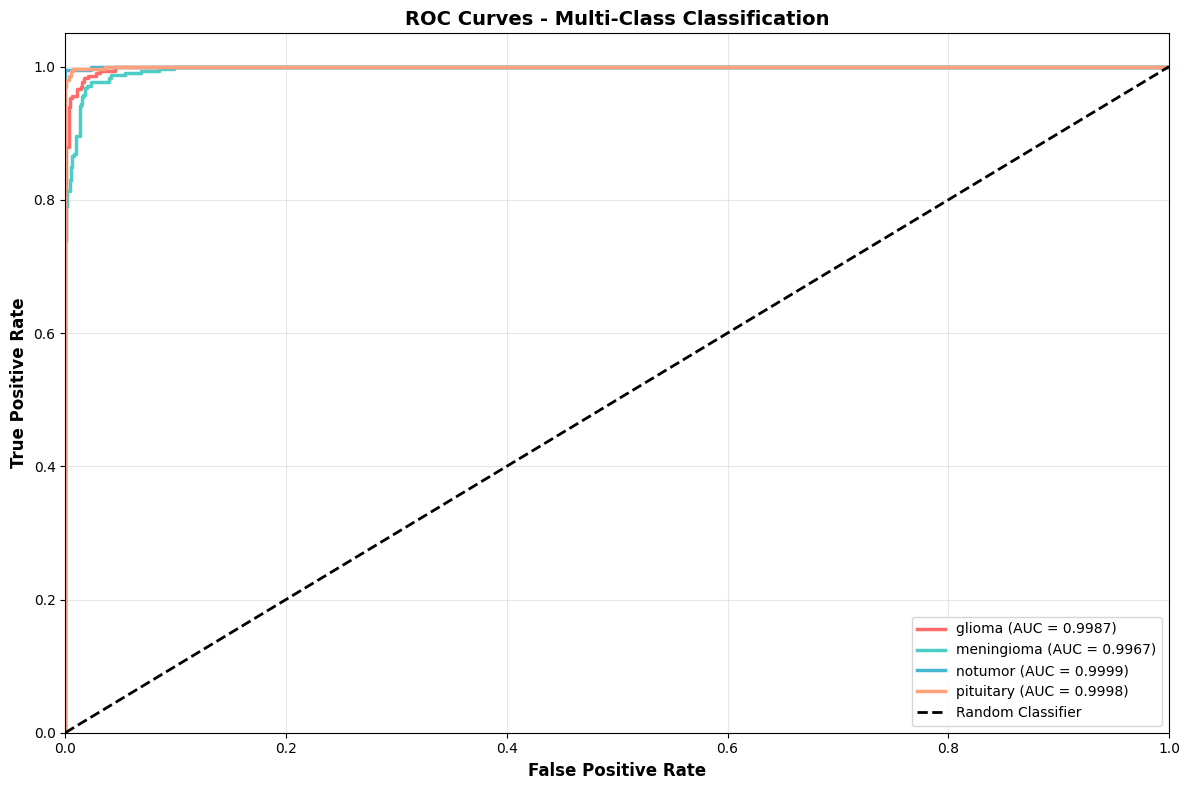


AUC Scores per Class:
glioma         : 0.9987
meningioma     : 0.9967
notumor        : 0.9999
pituitary      : 0.9998
Mean AUC       : 0.9988


In [61]:
# =============================================================================
# CONFUSION MATRIX
# =============================================================================

class EvaluationVisualizer:
    """Advanced evaluation visualizations"""

    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, class_names):
        """Plot enhanced confusion matrix"""

        cm = confusion_matrix(y_true, y_pred)

        # Calculate percentages
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Absolute counts
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names,
                   cbar_kws={'label': 'Count'}, ax=ax1)
        ax1.set_title('Confusion Matrix - Absolute Counts',
                     fontsize=14, fontweight='bold', pad=20)
        ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
        ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')

        # Percentages
        sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='RdYlGn',
                   xticklabels=class_names, yticklabels=class_names,
                   cbar_kws={'label': 'Percentage (%)'}, ax=ax2)
        ax2.set_title('Confusion Matrix - Percentages',
                     fontsize=14, fontweight='bold', pad=20)
        ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
        ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Print per-class accuracy
        print("\nPer-Class Accuracy:")
        print("="*50)
        for i, class_name in enumerate(class_names):
            class_acc = cm[i, i] / cm[i].sum() * 100
            print(f"{class_name:15s}: {class_acc:6.2f}%")
        print("="*50)

    @staticmethod
    def plot_roc_curves(y_true, y_pred_proba, class_names):
        """Plot ROC curves for all classes"""

        # Binarize labels
        y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

        # Compute ROC curve and AUC for each class
        fpr, tpr, roc_auc = {}, {}, {}

        plt.figure(figsize=(12, 8))

        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

        for i, (class_name, color) in enumerate(zip(class_names, colors)):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

            plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
                    label=f'{class_name} (AUC = {roc_auc[i]:.4f})')

        # Plot diagonal
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
        plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
        plt.title('ROC Curves - Multi-Class Classification',
                 fontsize=14, fontweight='bold')
        plt.legend(loc='lower right', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Print AUC scores
        print("\nAUC Scores per Class:")
        print("="*50)
        for i, class_name in enumerate(class_names):
            print(f"{class_name:15s}: {roc_auc[i]:.4f}")
        print(f"{'Mean AUC':15s}: {np.mean(list(roc_auc.values())):.4f}")
        print("="*50)

# Plot confusion matrix
EvaluationVisualizer.plot_confusion_matrix(
    test_labels_encoded,
    test_pred_classes,
    Config.CLASS_NAMES
)

# Plot ROC curves
EvaluationVisualizer.plot_roc_curves(
    test_labels_encoded,
    test_predictions,
    Config.CLASS_NAMES
)

In [62]:
# =============================================================================
# SAVE FINAL MODEL
# =============================================================================

print("\n" + "="*80)
print("SAVING FINAL MODEL")
print("="*80)

# Save model
model.save(Config.MODEL_SAVE_PATH)
print(f"\n✓ Model saved successfully to:")
print(f"  {Config.MODEL_SAVE_PATH}")

# Save model architecture as JSON
model_json = model.to_json()
json_path = Config.MODEL_SAVE_PATH.replace('.h5', '_architecture.json')
with open(json_path, 'w') as json_file:
    json_file.write(model_json)
print(f"✓ Model architecture saved to:")
print(f"  {json_path}")

# Save training history
history_path = Config.MODEL_SAVE_PATH.replace('.h5', '_history.npy')
np.save(history_path, history.history)
print(f"✓ Training history saved to:")
print(f"  {history_path}")

print("\n" + "="*80)
print("MODEL SAVE COMPLETE")
print("="*80)


SAVING FINAL MODEL

✓ Model saved successfully to:
  /content/drive/MyDrive/brain_tumor_model_vgg16.h5
✓ Model architecture saved to:
  /content/drive/MyDrive/brain_tumor_model_vgg16_architecture.json
✓ Training history saved to:
  /content/drive/MyDrive/brain_tumor_model_vgg16_history.npy

MODEL SAVE COMPLETE


In [63]:
# =============================================================================
# MODEL INFERENCE CLASS
# =============================================================================

class BrainTumorDetector:
    """
    Professional inference class for brain tumor detection
    """

    def __init__(self, model_path: str = None):
        """
        Initialize detector with trained model

        Args:
            model_path: Path to saved .h5 model file
        """
        if model_path is None:
            model_path = Config.MODEL_SAVE_PATH

        print(f"Loading model from: {model_path}")
        self.model = load_model(model_path)
        self.class_names = Config.CLASS_NAMES
        self.image_size = Config.IMAGE_SIZE
        print("✓ Model loaded successfully")

    def preprocess_image(self, image_path: str) -> np.ndarray:
        """Preprocess image for prediction"""
        img = load_img(image_path, target_size=(self.image_size, self.image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array

    def predict(self, image_path: str, return_probabilities: bool = False):
        """
        Make prediction on a single image

        Args:
            image_path: Path to image file
            return_probabilities: Whether to return class probabilities

        Returns:
            Dictionary with prediction results
        """
        try:
            # Preprocess image
            img_array = self.preprocess_image(image_path)

            # Make prediction
            predictions = self.model.predict(img_array, verbose=0)
            predicted_class_idx = np.argmax(predictions[0])
            confidence = predictions[0][predicted_class_idx]
            predicted_class = self.class_names[predicted_class_idx]

            result = {
                'predicted_class': predicted_class,
                'confidence': float(confidence),
                'is_tumor': predicted_class != 'notumor'
            }

            if return_probabilities:
                result['probabilities'] = {
                    class_name: float(prob)
                    for class_name, prob in zip(self.class_names, predictions[0])
                }

            return result

        except Exception as e:
            return {'error': str(e)}

    def predict_and_visualize(self, image_path: str, figsize: Tuple = (12, 5)):
        """
        Make prediction and visualize results

        Args:
            image_path: Path to image file
            figsize: Figure size for visualization
        """
        result = self.predict(image_path, return_probabilities=True)

        if 'error' in result:
            print(f"Error: {result['error']}")
            return

        # Load image for display
        img = Image.open(image_path)
        img_resized = img.resize((self.image_size, self.image_size))

        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Display image
        ax1.imshow(img_resized, cmap='gray')
        ax1.axis('off')

        # Title with prediction
        if result['is_tumor']:
            title_color = 'red'
            title = f"TUMOR DETECTED: {result['predicted_class'].upper()}"
        else:
            title_color = 'green'
            title = "NO TUMOR DETECTED"

        ax1.set_title(title, fontsize=14, fontweight='bold',
                     color=title_color, pad=15)

        # Display probabilities
        classes = list(result['probabilities'].keys())
        probs = list(result['probabilities'].values())

        colors = ['red' if result['predicted_class'] == c else 'skyblue'
                 for c in classes]

        bars = ax2.barh(classes, probs, color=colors)
        ax2.set_xlabel('Probability', fontsize=12, fontweight='bold')
        ax2.set_title('Class Probabilities', fontsize=14, fontweight='bold')
        ax2.set_xlim([0, 1])

        # Add percentage labels
        for bar, prob in zip(bars, probs):
            width = bar.get_width()
            ax2.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                    f'{prob*100:.2f}%', ha='left', va='center',
                    fontweight='bold', fontsize=10)

        ax2.grid(axis='x', alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print detailed results
        print("\n" + "="*60)
        print("DETECTION RESULTS")
        print("="*60)
        print(f"Image: {os.path.basename(image_path)}")
        print(f"Prediction: {result['predicted_class'].upper()}")
        print(f"Confidence: {result['confidence']*100:.2f}%")
        print(f"Tumor Status: {'POSITIVE' if result['is_tumor'] else 'NEGATIVE'}")
        print("="*60)
        print("\nClass Probabilities:")
        for class_name, prob in result['probabilities'].items():
            print(f"  {class_name:15s}: {prob*100:6.2f}%")
        print("="*60)


In [64]:
# =============================================================================
# LOAD AND TEST THE SAVED MODEL
# =============================================================================

print("\n" + "="*80)
print("TESTING SAVED MODEL")
print("="*80 + "\n")

# Initialize detector
detector = BrainTumorDetector(Config.MODEL_SAVE_PATH)



TESTING SAVED MODEL

Loading model from: /content/drive/MyDrive/brain_tumor_model_vgg16.h5


✓ Model loaded successfully



DEMONSTRATION: PREDICTIONS ON TEST IMAGES


Testing on: GLIOMA


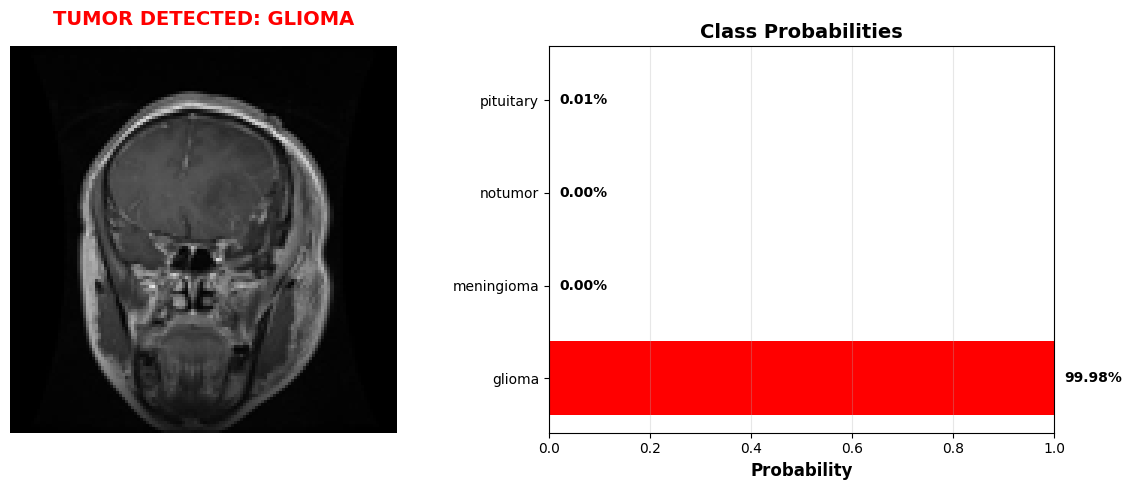


DETECTION RESULTS
Image: Te-gl_0039.jpg
Prediction: GLIOMA
Confidence: 99.98%
Tumor Status: POSITIVE

Class Probabilities:
  glioma         :  99.98%
  meningioma     :   0.00%
  notumor        :   0.00%
  pituitary      :   0.01%

Testing on: MENINGIOMA


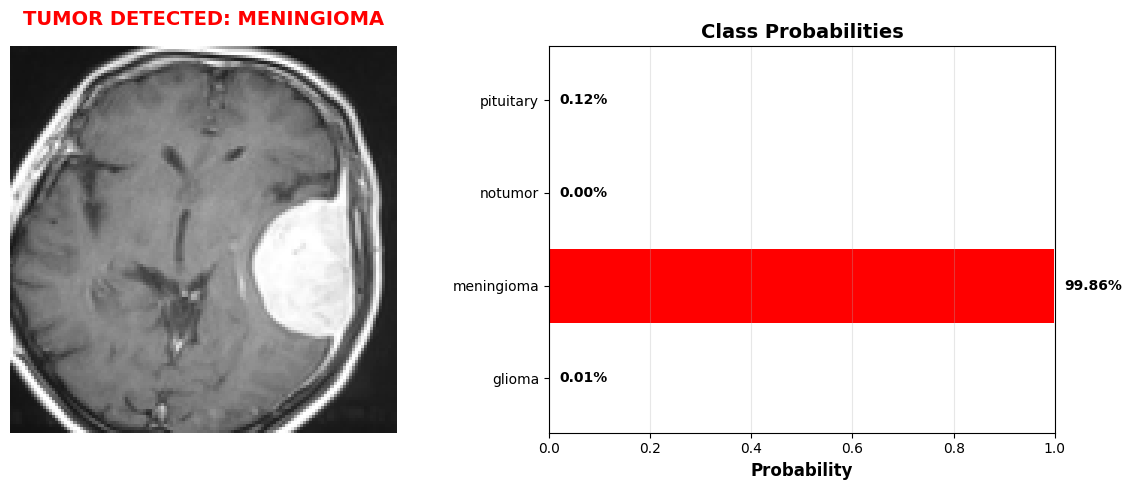


DETECTION RESULTS
Image: Te-me_0012.jpg
Prediction: MENINGIOMA
Confidence: 99.86%
Tumor Status: POSITIVE

Class Probabilities:
  glioma         :   0.01%
  meningioma     :  99.86%
  notumor        :   0.00%
  pituitary      :   0.12%

Testing on: NOTUMOR


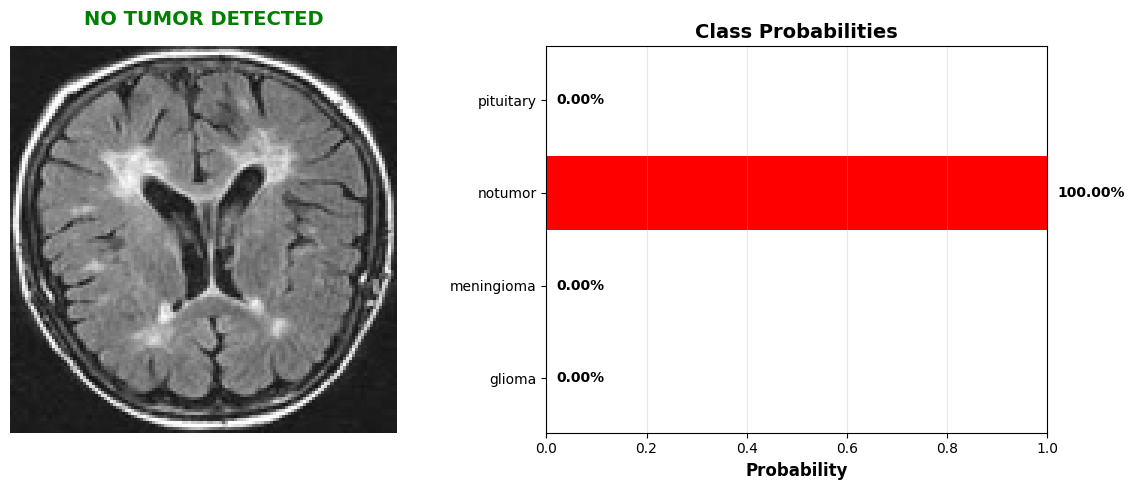


DETECTION RESULTS
Image: Te-no_0396.jpg
Prediction: NOTUMOR
Confidence: 100.00%
Tumor Status: NEGATIVE

Class Probabilities:
  glioma         :   0.00%
  meningioma     :   0.00%
  notumor        : 100.00%
  pituitary      :   0.00%

Testing on: PITUITARY


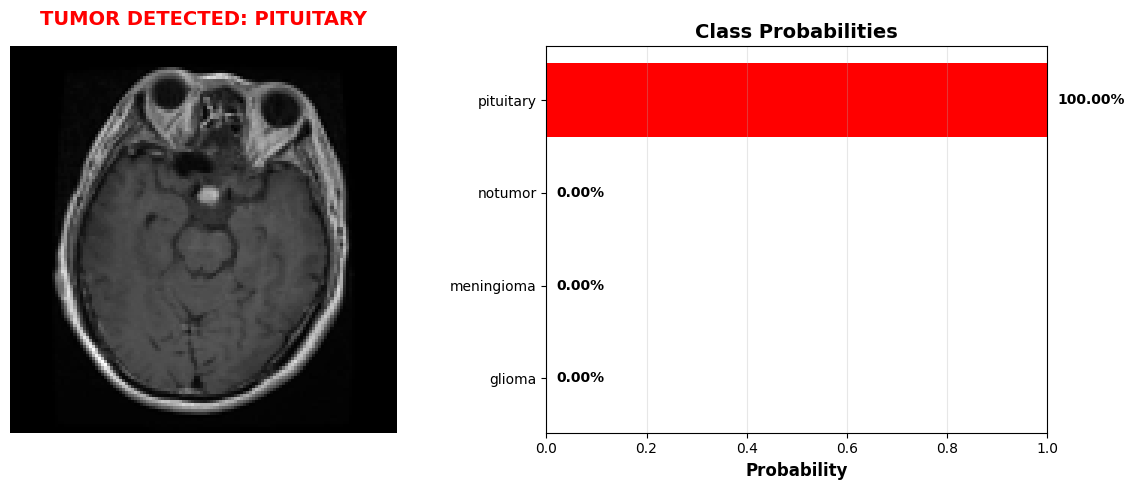


DETECTION RESULTS
Image: Te-pi_0170.jpg
Prediction: PITUITARY
Confidence: 100.00%
Tumor Status: POSITIVE

Class Probabilities:
  glioma         :   0.00%
  meningioma     :   0.00%
  notumor        :   0.00%
  pituitary      : 100.00%


In [65]:
# =============================================================================
# DEMONSTRATION: PREDICT ON TEST IMAGES
# =============================================================================

print("\n" + "="*80)
print("DEMONSTRATION: PREDICTIONS ON TEST IMAGES")
print("="*80 + "\n")

# Select random test images from each class
demo_images = {}
for class_name in Config.CLASS_NAMES:
    class_dir = os.path.join(Config.TEST_DIR, class_name)
    if os.path.exists(class_dir):
        images = [f for f in os.listdir(class_dir)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if images:
            demo_images[class_name] = os.path.join(class_dir, random.choice(images))

# Test on each class
for class_name, image_path in demo_images.items():
    print(f"\n{'='*60}")
    print(f"Testing on: {class_name.upper()}")
    print(f"{'='*60}")
    detector.predict_and_visualize(image_path)